# Model Deployment Image Classification Submission for Dicoding
# Convert built model into Tflite

## Nama : Dimas Adhitya Suwarto
## e-mail : s.adhitya.dimas@gmail.com
## Hp : 082137099393

## Intel Image Classification
## source : Kaggle
## link to dataset : https://www.kaggle.com/puneet6060/intel-image-classification/

### 13.500 samples

## Files already split between train and test 80:20
## No need to manually split again

In [ ]:
#install required library first
! pip install -q kaggle 
from google.colab import files
files.upload() #upload api keys from kaggle, use your own api keys

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                           title                                              size  lastUpdated          downloadCount  
------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                   Reddit Vaccine Myths                              232KB  2021-06-26 07:50:27           8368  
crowww/a-large-scale-fish-dataset                             A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           5124  
imsparsh/musicnet-dataset                                     MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1741  
promptcloud/careerbuilder-job-listing-2020                    Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52           1168  
coloradokb/dandelionimages                                    Da

In [ ]:
# Download dataset from kaggle
! kaggle datasets download -d puneet6060/intel-image-classification

 99% 342M/346M [00:02<00:00, 129MB/s]
100% 346M/346M [00:02<00:00, 121MB/s]


In [ ]:
# create intel directory and unzip the downloaded zip into it
! mkdir intel
! unzip intel-image-classification.zip -d intel

Streaming output truncated to the last 5000 lines.
  inflating: intel/seg_train/seg_train/mountain/7506.jpg  
  inflating: intel/seg_train/seg_train/mountain/7537.jpg  
  inflating: intel/seg_train/seg_train/mountain/7539.jpg  
  inflating: intel/seg_train/seg_train/mountain/7551.jpg  
  inflating: intel/seg_train/seg_train/mountain/7560.jpg  
  inflating: intel/seg_train/seg_train/mountain/7565.jpg  
  inflating: intel/seg_train/seg_train/mountain/7578.jpg  
  inflating: intel/seg_train/seg_train/mountain/7581.jpg  
  inflating: intel/seg_train/seg_train/mountain/7586.jpg  
  inflating: intel/seg_train/seg_train/mountain/7647.jpg  
  inflating: intel/seg_train/seg_train/mountain/7652.jpg  
  inflating: intel/seg_train/seg_train/mountain/7654.jpg  
  inflating: intel/seg_train/seg_train/mountain/7662.jpg  
  inflating: intel/seg_train/seg_train/mountain/767.jpg  
  inflating: intel/seg_train/seg_train/mountain/7672.jpg  
  inflating: intel/seg_train/seg_train/mountain/7679.jpg  
  infl

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from google.colab import files
import zipfile,os 
import pandas as pd

In [ ]:
#target directory
target_dir = '/content/intel'

In [ ]:
!pip install seedir #for directory treeview 
import seedir as sd 
#check dataset directory
sd.seedir(target_dir, style='lines', itemlimit=4, depthlimit=3)

intel/
├─seg_train/
│ └─seg_train/
│   ├─buildings/
│   ├─sea/
│   ├─forest/
│   └─street/
├─seg_test/
│ └─seg_test/
│   ├─buildings/
│   ├─sea/
│   ├─forest/
│   └─street/
└─seg_pred/
  └─seg_pred/
    ├─17943.jpg
    ├─10363.jpg
    ├─13971.jpg
    └─14210.jpg


In [ ]:
#There are 6 classes
# But i'm going to use only 5 for faster model learning
# Delete Glacier class
#delete glacier folder
import shutil
shutil.rmtree('/content/intel/seg_train/seg_train/glacier', ignore_errors=True)
shutil.rmtree('/content/intel/seg_test/seg_test/glacier', ignore_errors=True)

In [ ]:
#Check class(folder)
landscape = os.path.join('/content/intel/seg_train/seg_train/')

print(os.listdir(landscape))

['buildings', 'sea', 'forest', 'street', 'mountain']


Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)


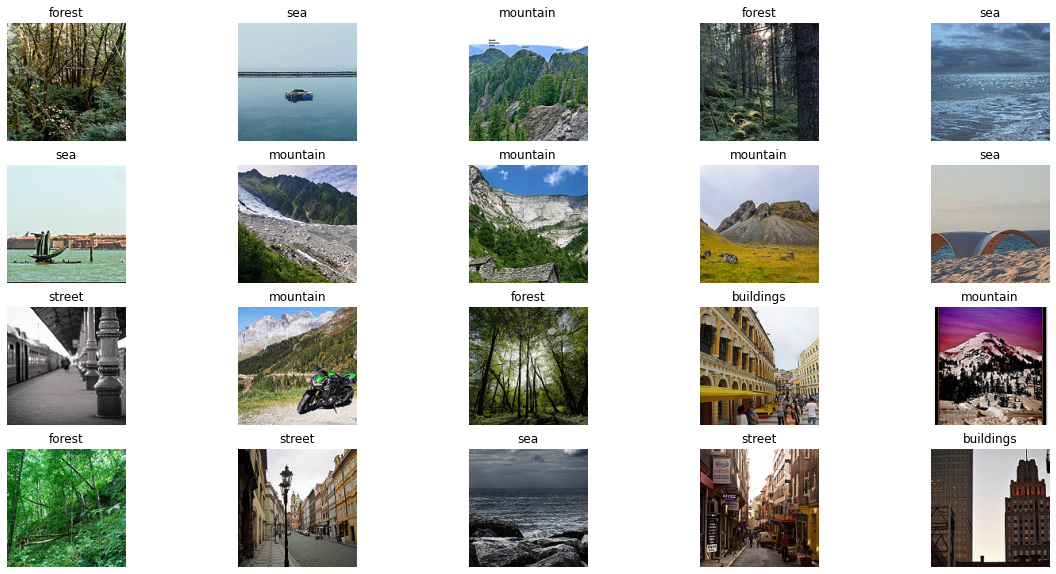

In [ ]:
#Display random images
import random

#function for displaying 1 random image and image shape
def one_random_image(target_path, target_class): 
  target_fold = target_path + target_class
  random_image = random.sample(os.listdir(target_fold), 1)
  image = mpimg.imread(target_fold+'/'+random_image[0])
  plt.imshow(image)
  plt.title(target_class)
  plt.axis('off');
  print(f"Image shape {image.shape}")

  return image

#Function for displaying group of random images and shape
def group_random_images( target_path, figure_size=(20, 10), group=20):
  plt.figure(figsize=figure_size)
  for i in range(group):
    plt.subplot(4, 5, i+1)
    class_name = random.choice(['buildings', 'forest', 'mountain', 'sea', 'street'])
    image = one_random_image(target_path=target_path, target_class=class_name)
  
group_random_images = group_random_images(target_path='/content/intel/seg_train/seg_train/')

### Count the total files in the dataset pre and post split

In [ ]:
#count total files inside original dataset, and total files after train and validation set split
train_path = '/content/intel/seg_train/seg_train/'
test_path = '/content/intel/seg_test/seg_test/'
folder_names = ['buildings', 'forest', 'mountain', 'sea', 'street']

train_files = {}
val_files = {}

for i in folder_names:
    train_files[i] = len(os.listdir(train_path+i))
    val_files[i] = len(os.listdir(test_path+i))

    
#convert to dataframe for easier comprehension
result_split = pd.DataFrame()
result_split = result_split.append(train_files, ignore_index=True)
result_split = result_split.append(val_files, ignore_index=True)
result_split['total'] = result_split.sum(axis=1)
result_split['type'] = ['train', 'val']
result_split = result_split[['type', 'buildings', 'forest', 'mountain', 'sea', 'street', 'total']]
print(result_split)

    type  buildings  forest  mountain     sea  street    total
0  train     2191.0  2271.0    2512.0  2274.0  2382.0  11630.0
1    val      437.0   474.0     525.0   510.0   501.0   2447.0


In [ ]:
#Train test composition
2447/(11630+2447)

0.17382965120409177

In [ ]:
## saving train and validation path into variable
train_set = '/content/intel/seg_train/seg_train'
val_set = '/content/intel/seg_test/seg_test'

In [ ]:
#image augmentation
#training set rescale and augmenting
train_aug = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    horizontal_flip=True,
                    zoom_range=0.2,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

#only rescale the validation set, dont do the augmentation step for validation set, it might cause bias
valid_aug = ImageDataGenerator(rescale=1./255)

In [ ]:
#train and validation data generator
#batch size 128
#class mode is categorical since we have 5 classes
train_generator = train_aug.flow_from_directory(
        train_set,  
        target_size=(150, 150),  
        batch_size=128,
        class_mode='categorical')

validation_generator = valid_aug.flow_from_directory(
        val_set, 
        target_size=(150, 150), 
        batch_size=128, 
        class_mode='categorical')

Found 11630 images belonging to 5 classes.
Found 2447 images belonging to 5 classes.


## Build  conVnet Model

In [ ]:
#building model 
#using 2 hidden layer 
#using softmax in output layer instead of sigmoid because there are 6 outcomes
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape= (150,150,3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64,(3,3), activation= 'relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128,(3,3), activation= 'relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation= 'relu'),
    layers.Dense(5, activation= 'softmax')
])

In [ ]:
# Adding lose function and optimizer
#categorical since we have 3 classes
#using adam 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') >= 0.85):
      self.model.stop_training = True
      print("\nValidation ACcuracy of the model >= 85%")
early_stop = myCallback()

In [ ]:
# Training the model
history = model.fit(
    train_generator,
    epochs=40, 
    steps_per_epoch=20,
    validation_data = validation_generator,
    verbose = 1,
    validation_steps=10,
    callbacks=[early_stop],
)

Epoch 1/40
20/20 [==============================] - 124s 6s/step - loss: 1.5503 - accuracy: 0.3277 - val_loss: 1.0643 - val_accuracy: 0.5773
Epoch 2/40
20/20 [==============================] - 123s 6s/step - loss: 1.0281 - accuracy: 0.5875 - val_loss: 1.0355 - val_accuracy: 0.6008
Epoch 3/40
20/20 [==============================] - 123s 6s/step - loss: 0.9603 - accuracy: 0.6105 - val_loss: 0.8605 - val_accuracy: 0.6766
Epoch 4/40
20/20 [==============================] - 123s 6s/step - loss: 0.8693 - accuracy: 0.6453 - val_loss: 0.8240 - val_accuracy: 0.6609
Epoch 5/40
20/20 [==============================] - 122s 6s/step - loss: 0.8281 - accuracy: 0.6554 - val_loss: 0.7350 - val_accuracy: 0.6961
Epoch 6/40
20/20 [==============================] - 123s 6s/step - loss: 0.7710 - accuracy: 0.6855 - val_loss: 0.7066 - val_accuracy: 0.7266
Epoch 7/40
20/20 [==============================] - 122s 6s/step - loss: 0.7752 - accuracy: 0.6876 - val_loss: 0.7076 - val_accuracy: 0.7109
Epoch 8/40
20

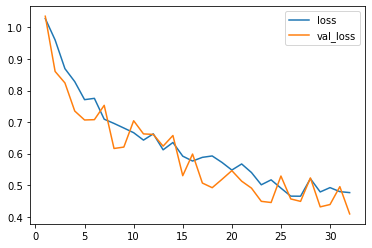

In [ ]:
#loss 
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
plt.show()

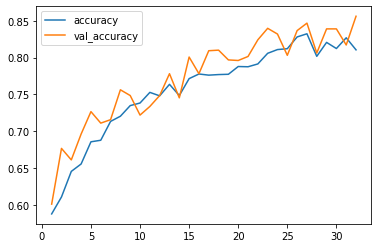

In [ ]:
#accuracy 
history_df.loc[1:, ['accuracy', 'val_accuracy']].plot()
plt.show()

In [ ]:
#Best validation loss and accuracy score
print(("Best Validation Loss: {:0.2f}" +"\nBest Validation Accuracy: {:0.2f}").format(history_df['val_loss'].min(), history_df['val_accuracy'].max()))

Best Validation Loss: 0.41
Best Validation Accuracy: 0.86


## Convert Model to tflite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpf3ziw16y/assets


In [ ]:
#Download converted model
files.download('model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>